### MLS Data Visualization

Last modified: 10/10/2023

In [1]:
# Standard libraries
import os
import sys
import time

# 3rd party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Local imports
from mls_stats import Team, league_stats

In [2]:
def round_to_next_five(number: int) -> int:
    return (5 * (round(number/5 +1)))

Forward Passing Accuracy Stripplot (STL v. SKC)

In [3]:
stl = Team('STL', 'St. Louis City SC', 17012, '#ec1458', '#001544', '#fed500')
skc = Team('SKC', 'Sporting Kansas City', 421, '#0c2340', '#a5bad6', '#878b8c')
stl_df = stl.get_stats()
skc_df = skc.get_stats()
joint_stats = pd.concat([stl_df.all, skc_df.all], ignore_index=True)

/home/gtorrini/anaconda3/envs/gaby_mls/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/gtorrini/anaconda3/envs/gaby_mls/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/gtorrini/anaconda3/envs/gaby_mls/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.3333333333333333, 0.6588235294117647, 0.40784313725490196)) for an unfilled marker ('_').  Mat

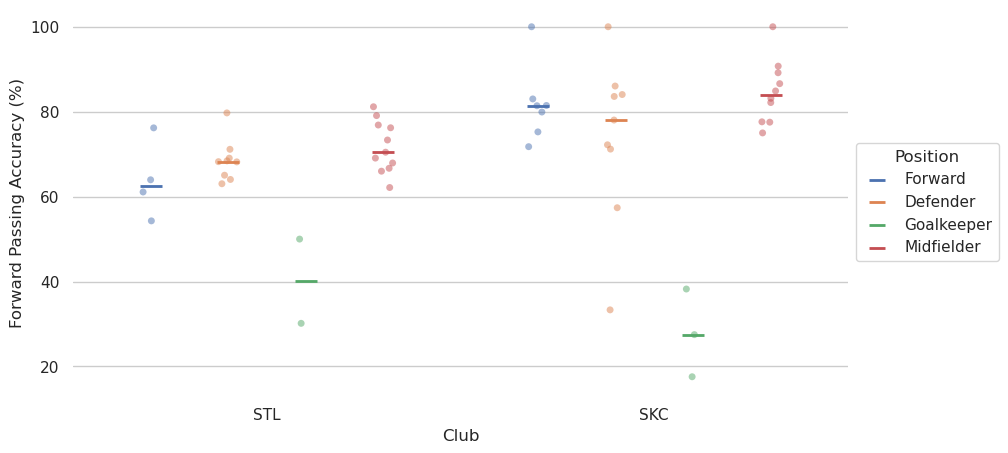

In [5]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(bottom=True, left=True)
sns.stripplot(data=joint_stats, x='club.abbreviation', y='regular_season_statistics.accurate_fwd_zone_pass_per', hue='position_generic', 
              hue_order=['Forward', 'Defender', 'Goalkeeper', 'Midfielder'], alpha=0.50, dodge=True, marker='o', legend=False)
pt_lines = sns.pointplot(data=joint_stats,  x='club.abbreviation', y='regular_season_statistics.accurate_fwd_zone_pass_per', hue='position_generic',
              hue_order=['Forward', 'Defender', 'Goalkeeper', 'Midfielder'], dodge=.6, estimator='median', markers='_', linestyles='none', errorbar=None)

for i in range(8, 12): 
    points = pt_lines.collections[i]
    size= points.get_sizes().item()
    new_sizes=[size*5]
    points.set_sizes(new_sizes)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, title='Position', markerscale=0.75)
ax.set(ylabel='Forward Passing Accuracy (%)', xlabel='Club');

Joint Plot

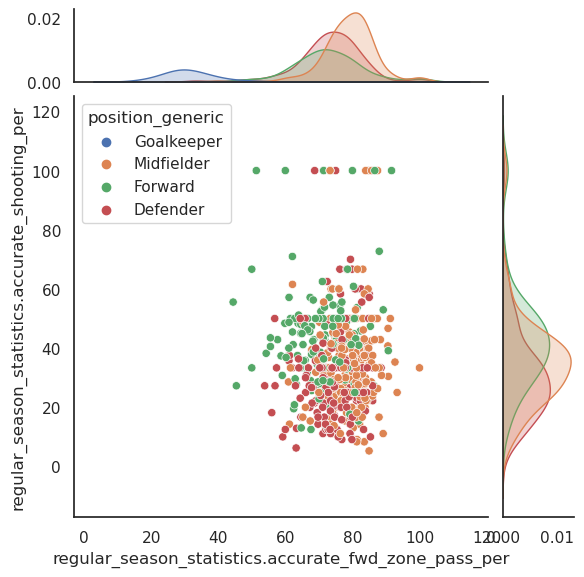

In [49]:
sns.jointplot(data=mls_df, x='regular_season_statistics.accurate_fwd_zone_pass_per', y='regular_season_statistics.accurate_bper', 
              hue='position_generic', marginal_ticks = True)

Cards Stacked Histogram (STL)

In [1]:
mls_df

NameError: name 'mls_df' is not defined

In [7]:
mls_df = league_stats(2023, 'players')

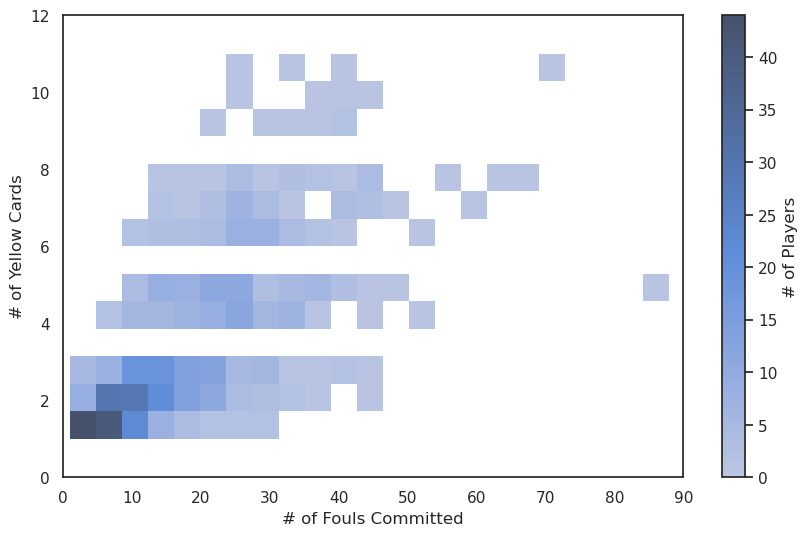

In [47]:
fig, ax = plt.subplots(figsize=(10,6))

sns.set_theme(style='white')
sns.histplot(data=mls_df, x='regular_season_statistics.fk_foul_lost', y='regular_season_statistics.yellow_card',
             cbar=True, cbar_kws={'label': '# of Players'})
ax.set(xlabel='# of Fouls Committed', ylabel='# of Yellow Cards', xlim=(0, 90), ylim=(0, 12));

Goals Pair Grid (League)

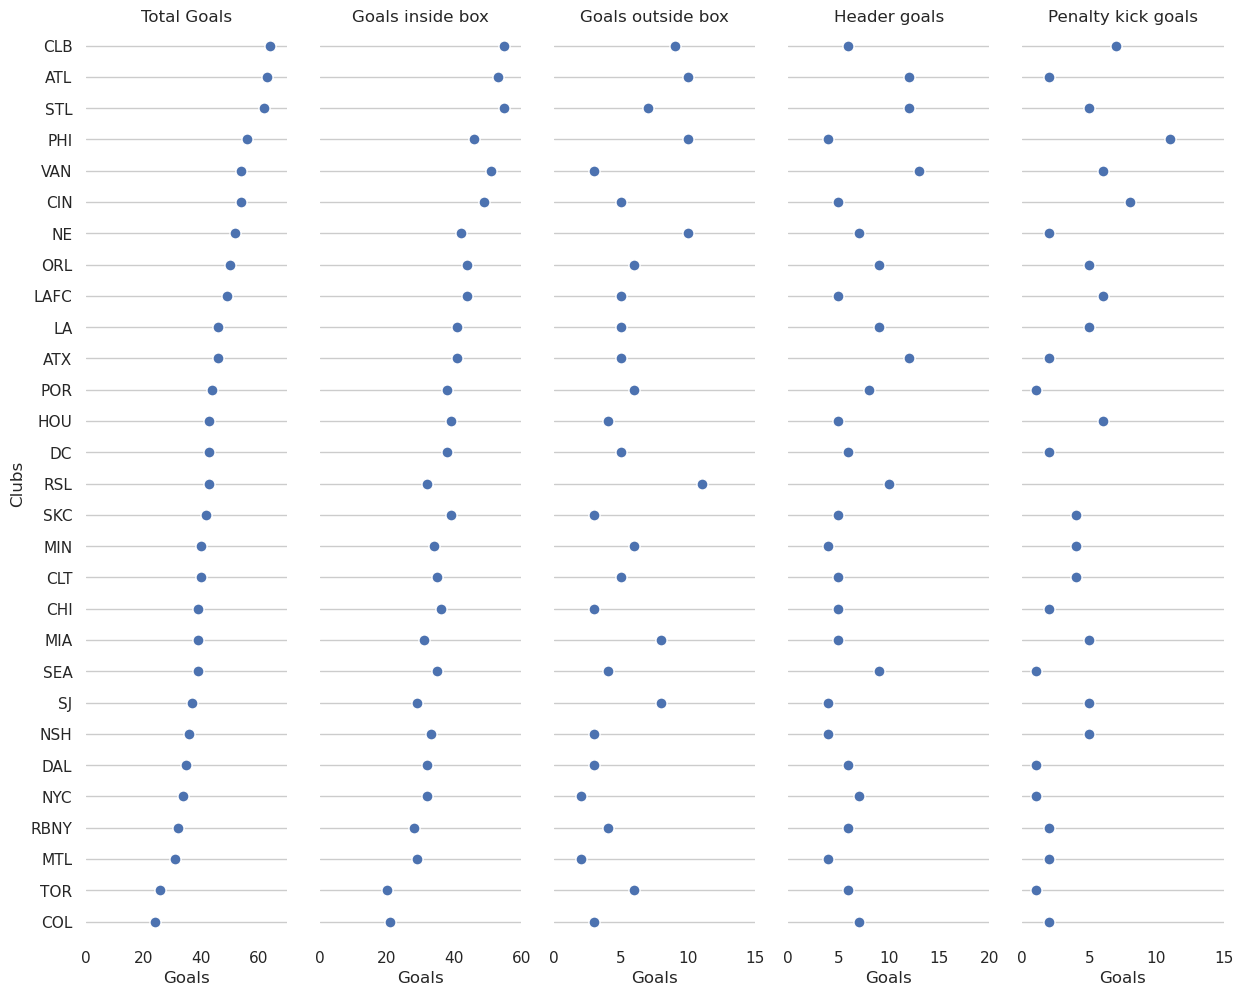

In [10]:
mls_df = league_stats(2023)

goal_cols = ['regular_season_statistics.goals', 'regular_season_statistics.att_ibox_goal', 'regular_season_statistics.att_obox_goal', 
             'regular_season_statistics.att_hd_goal', 'regular_season_statistics.att_pen_goal']

g = sns.PairGrid(mls_df.sort_values(by='regular_season_statistics.goals', ascending=False),
                 x_vars=goal_cols,
                 y_vars=['club.abbreviation'], height=10, aspect=.25)

g.map(sns.stripplot, size=8, orient='h', jitter=False, palette='flare_r', linewidth=1, edgecolor='w')
g.set(xlabel='Goals', ylabel='Clubs')

titles = ["Total Goals", "Goals inside box", "Goals outside box",
          "Header goals", "Penalty kick goals"]

for i, (ax, title) in enumerate(zip(g.axes.flat, titles)):

    # Set a different title for each axes
    ax.set(title=title, xlim=(0, round_to_next_five(mls_df[goal_cols[i]].max())))

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

Win-Draw-Loss Since 2000 (CLB)

In [11]:
clb = Team('CLB', 'Columbus Crew', 454, '#fddd00', '#000000', '#ffffff')
ner = Team('NE', 'New England Revolution', 928, '#0a2240', '#ce0e2d', '#ffffff')
wins = []
draws = []
losses = []

for i in range(2000, 2023):     # draws were only introduced to rules in 2000
    league_df = league_stats(i)
    clb_df = league_df[league_df['club.abbreviation'] == 'NE']
    wins.append(clb_df['regular_season_statistics.total_wins'].loc[clb_df.index[0]])
    draws.append(clb_df['regular_season_statistics.total_draws'].loc[clb_df.index[0]])
    losses.append(clb_df['regular_season_statistics.total_losses'].loc[clb_df.index[0]])

years = np.array(range(2000, 2023))
wdl_stats = {
    'Wins': np.array(wins),
    'Draws': np.array(draws),
    'Losses': np.array(losses),
}

[Text(0.5, 1.0, 'New England Revolution ')]

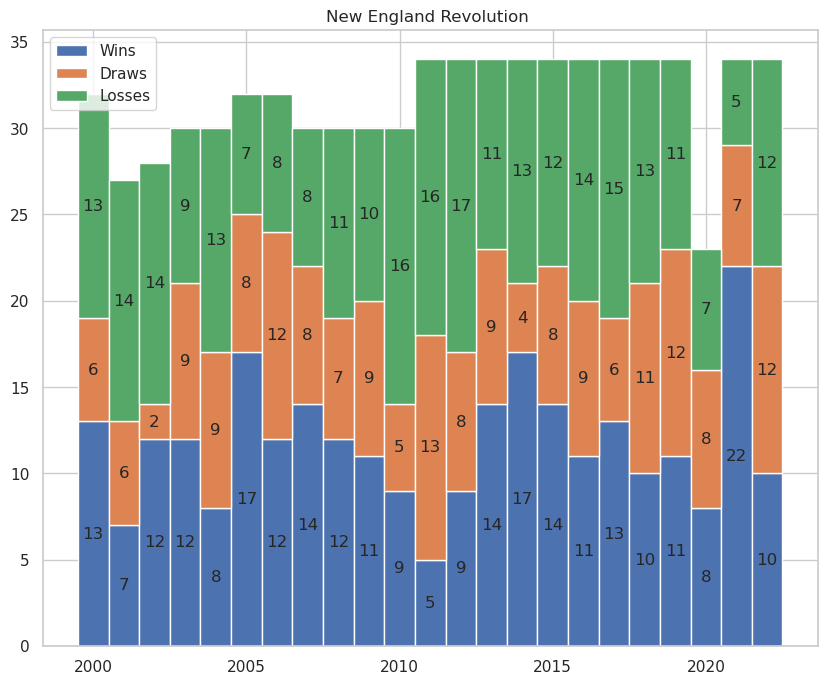

In [38]:
width = 1
bottom = np.zeros(23)

fig, ax = plt.subplots(figsize=(10, 8))
for result, wdl_stat in wdl_stats.items():
    p = ax.bar(years, wdl_stat, width, label=result, bottom=bottom)
    bottom += wdl_stat

    ax.bar_label(p, label_type='center')

ax.legend()
ax.set(title='New England Revolution ')


In [23]:
clb_df['regular_season_statistics.total_wins'].loc[clb_df.index[0]]

11

Win Rate Line Plot (Founding Teams)

In [18]:
for i in range(1996, 2023):
    league_df = league_stats(i)
    win_rate = (league_df['regular_season_statistics.total_wins']/league_df['regular_season_statistics.total_matches']) * 100
    if (i == 1996):
        founding_df = pd.DataFrame(data={'club.abbreviation': start['club.abbreviation'], ('win_rate_' + str(i)): win_rates})
        active_df = founding_df[founding_df['club.abbreviation'] != 'TB']     # remove entry for Tampa Bay Mutiny (discontinued/former)
    else:
        win_df = pd.DataFrame(data={'club.abbreviation': start['club.abbreviation'], ('win_rate_' + str(i)): win_rates})
        active_df = active_df.merge(win_df, how='inner', on='club.abbreviation')

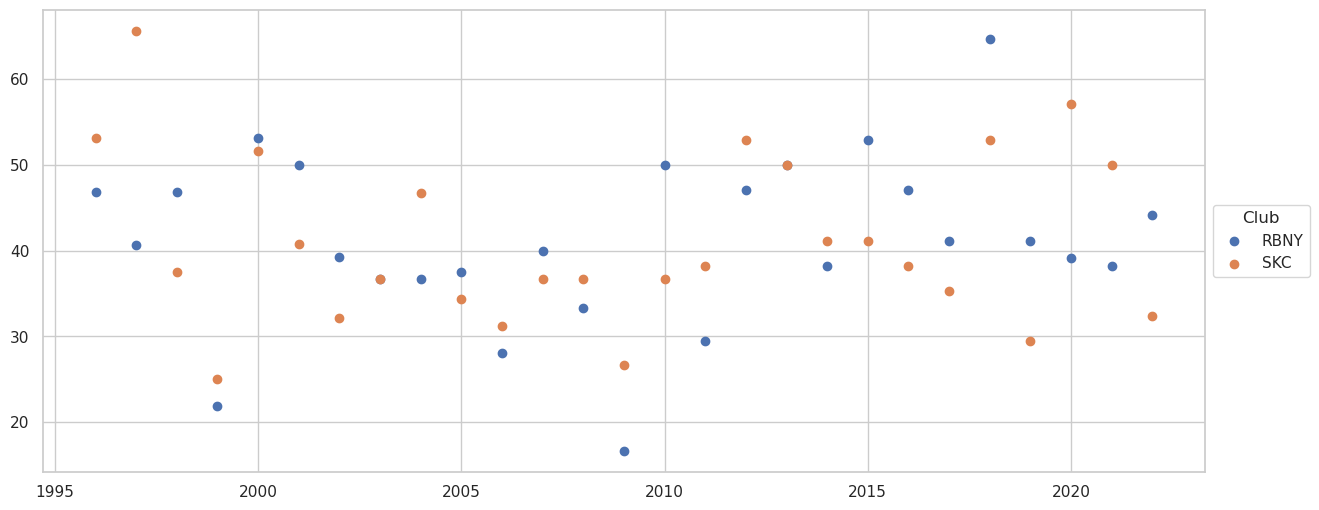

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

for i in range(2):
    y = active_df.iloc[i, 1:]
    ax.scatter(range(1996, 2023), y, label=active_df.iloc[i, 0])

ax.legend(loc='center left', title='Club', bbox_to_anchor=(1, 0.5))